In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vuppalaadithyasairam/anomaly-detection-in-water-pump-using-audio-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vuppalaadithyasairam/anomaly-detection-in-water-pump-using-audio-data/versions/1


In [11]:
import os

# Define the base directory for the dataset
base_path = path + "/water pump audio for anomaly detection/"

# Define paths to each specific subset of the dataset
anomaly_path = os.path.join(base_path, "anomaly")          # Path for anomalous audio files
train_normal_path = os.path.join(base_path, "train-normal") # Path for normal training audio files
test_normal_path = os.path.join(base_path, "test-normal")   # Path for normal testing audio files

# Function to count the number of `.wav` files in a directory
def count_files_in_directory(directory):
    """
    Counts the number of `.wav` files in a given directory.

    Args:
        directory (str): Path to the directory to analyze.

    Returns:
        int: Number of `.wav` files in the directory.
    """
    return len([file for file in os.listdir(directory) if file.endswith('.wav')])

# Count the number of files in each subset
anomaly_count = count_files_in_directory(anomaly_path)
train_normal_count = count_files_in_directory(train_normal_path)
test_normal_count = count_files_in_directory(test_normal_path)

# Print the analysis
print("Preliminary Dataset Analysis:")
print(f"Number of files in 'anomaly': {anomaly_count}")
print(f"Number of files in 'train-normal': {train_normal_count}")
print(f"Number of files in 'test-normal': {test_normal_count}")

Preliminary Dataset Analysis:
Number of files in 'anomaly': 456
Number of files in 'train-normal': 2241
Number of files in 'test-normal': 400


In [20]:
import librosa
import numpy as np

# Function to check if an audio file is valid
def check_audio_file(file_path):
    """
    Purpose:
        Ensures that each audio file is valid and can be successfully loaded.
        This avoids runtime errors during preprocessing and ensures the dataset's integrity.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        bool: True if the file is valid, False otherwise.
    """
    try:
        # Attempt to load the file to check if it's readable
        librosa.load(file_path, sr=None)
        return True
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return False

# Validate files in each dataset
# Purpose: Filter out corrupt or unreadable files to ensure smooth preprocessing and model training.
print("Validating audio files...")

anomaly_valid = [file for file in os.listdir(anomaly_path) if file.endswith('.wav') and check_audio_file(os.path.join(anomaly_path, file))]
train_normal_valid = [file for file in os.listdir(train_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(train_normal_path, file))]
test_normal_valid = [file for file in os.listdir(test_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(test_normal_path, file))]

# Print counts of valid files
print(f"Valid files in 'anomaly': {len(anomaly_valid)}")
print(f"Valid files in 'train-normal': {len(train_normal_valid)}")
print(f"Valid files in 'test-normal': {len(test_normal_valid)}")

def normalize_mfcc(mfcc):
    """
    Normalizes MFCC features to the range [0, 1].

    Args:
        mfcc (np.ndarray): MFCC features of shape (time x features).

    Returns:
        np.ndarray: Normalized MFCC features.
    """
    return (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc) + 1e-8)

def preprocess_audio(file_path, sr=22050, n_mfcc=13, max_duration=5):
    """
    Preprocesses an audio file to normalize, trim/pad to a fixed duration,
    and extract normalized Mel-Frequency Cepstral Coefficients (MFCC).

    Args:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate to use when loading the audio (default: 22050 Hz).
        n_mfcc (int): Number of MFCC features to extract (default: 13).
        max_duration (int): Maximum duration of the audio in seconds (default: 5).

    Returns:
        np.ndarray: Transposed and normalized MFCC feature array (shape: time x features).
    """
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=sr)

    # Normalize the audio signal
    signal = signal / np.max(np.abs(signal))

    # Pad or trim the signal to ensure uniform length
    max_length = sr * max_duration
    if len(signal) < max_length:
        signal = np.pad(signal, (0, max_length - len(signal)), 'constant')
    else:
        signal = signal[:max_length]

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    # Normalize the MFCC features
    normalized_mfcc = normalize_mfcc(mfcc)

    # Transpose to (time x features)
    return normalized_mfcc.T


# Function to preprocess a directory
def preprocess_directory(valid_files, directory):
    """
    Purpose:
        Apply the preprocessing function to all valid audio files in a directory
        to prepare data for training or evaluation.

    Args:
        valid_files (list): List of valid file names.
        directory (str): Path to the directory containing the files.

    Returns:
        np.ndarray: Array of preprocessed audio features.
    """
    data = []
    for file in valid_files:
        file_path = os.path.join(directory, file)
        mfcc = preprocess_audio(file_path)
        data.append(mfcc)
    return np.array(data)

# Preprocess all datasets
# Purpose: Convert raw audio files into structured numerical data for model input.
print("Preprocessing audio files...")

anomaly_data = preprocess_directory(anomaly_valid, anomaly_path)
train_normal_data = preprocess_directory(train_normal_valid, train_normal_path)
test_normal_data = preprocess_directory(test_normal_valid, test_normal_path)

# Print dimensions of preprocessed datasets
print(f"Anomaly Data Shape: {anomaly_data.shape}")
print(f"Train Normal Data Shape: {train_normal_data.shape}")
print(f"Test Normal Data Shape: {test_normal_data.shape}")

# Function to flatten data
def flatten_data(data):
    """
    Purpose:
        Flatten 2D MFCC feature arrays (time x features) into 1D arrays
        for compatibility with dense neural networks or simpler models.

    Args:
        data (np.ndarray): Array of MFCC features.

    Returns:
        np.ndarray: Flattened array for each audio file.
    """
    return np.array([x.flatten() for x in data])

# Flatten the data
# Purpose: Transform MFCC features to a format compatible with dense networks.
anomaly_flattened = flatten_data(anomaly_data)
train_normal_flattened = flatten_data(train_normal_data)
test_normal_flattened = flatten_data(test_normal_data)


# Print flattened data shapes
print(f"Anomaly Flattened Shape: {anomaly_flattened.shape}")
print(f"Train Normal Flattened Shape: {train_normal_flattened.shape}")
print(f"Test Normal Flattened Shape: {test_normal_flattened.shape}")

Validating audio files...
Valid files in 'anomaly': 456
Valid files in 'train-normal': 2241
Valid files in 'test-normal': 400
Preprocessing audio files...
Anomaly Data Shape: (456, 216, 13)
Train Normal Data Shape: (2241, 216, 13)
Test Normal Data Shape: (400, 216, 13)
Anomaly Flattened Shape: (456, 2808)
Train Normal Flattened Shape: (2241, 2808)
Test Normal Flattened Shape: (400, 2808)


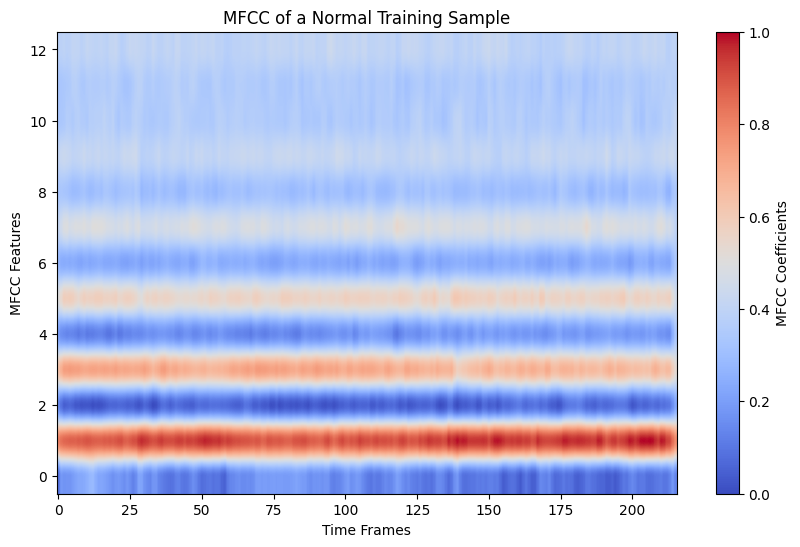

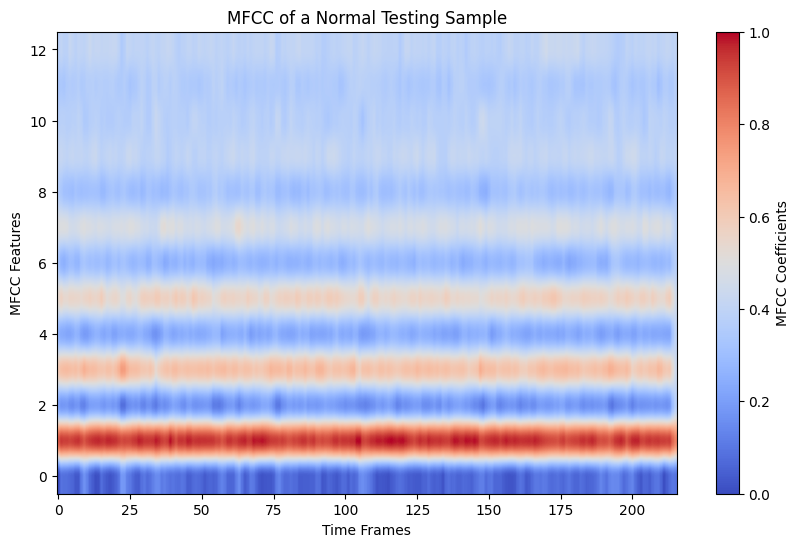

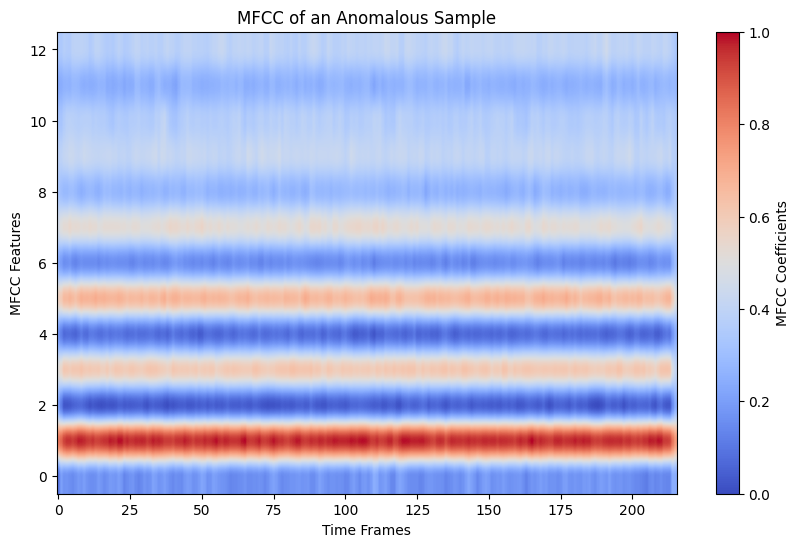

In [21]:
import matplotlib.pyplot as plt
import random

# Visualizza un esempio di MFCC dal dataset pre-elaborato
def visualize_processed_mfcc(mfcc_data, title="Processed MFCC"):
    """
    Visualize the MFCC data that has already been preprocessed.

    Args:
        mfcc_data (np.ndarray): Preprocessed MFCC data (time x features).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(mfcc_data.T, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label='MFCC Coefficients')
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Features')
    plt.show()

# Visualizza un campione casuale da train_normal_data
random_index_train = random.randint(0, len(train_normal_data) - 1)
sample_mfcc_train = train_normal_data[random_index_train]
visualize_processed_mfcc(sample_mfcc_train, title="MFCC of a Normal Training Sample")

# Visualizza un campione casuale da test_normal_data
random_index_test = random.randint(0, len(test_normal_data) - 1)
sample_mfcc_test = test_normal_data[random_index_test]
visualize_processed_mfcc(sample_mfcc_test, title="MFCC of a Normal Testing Sample")

# Visualizza un campione casuale da anomaly_data
random_index_anomaly = random.randint(0, len(anomaly_data) - 1)
sample_mfcc_anomaly = anomaly_data[random_index_anomaly]
visualize_processed_mfcc(sample_mfcc_anomaly, title="MFCC of an Anomalous Sample")


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),  # Compress to 1024
            nn.ReLU(),
            nn.Linear(1024, 512),       # Compress to 512
            nn.ReLU(),
            nn.Linear(512, latent_dim)  # Compress to latent_dim
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512), # Expand to 512
            nn.ReLU(),
            nn.Linear(512, 1024),       # Expand to 1024
            nn.ReLU(),
            nn.Linear(1024, input_dim), # Expand back to original size
            nn.Sigmoid()                # Output between 0 and 1
        )

    def forward(self, x):
        z = self.encoder(x)          # Compress input to latent space
        x_reconstructed = self.decoder(z)  # Reconstruct input from latent space
        return z, x_reconstructed

# Parameters
input_dim = 2808  # Flattened MFCC feature size
latent_dim = 64   # Dimension of the latent space

# Initialize the Autoencoder model
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare DataLoader for training
train_flattened = torch.tensor(train_normal_data.reshape(len(train_normal_data), -1), dtype=torch.float32)
train_loader = DataLoader(TensorDataset(train_flattened), batch_size=64, shuffle=True)

# Training loop
epochs = 50
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch[0]  # Input data
        z, x_reconstructed = model(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 0.0106
Epoch 2/50, Loss: 0.0031
Epoch 3/50, Loss: 0.0026
Epoch 4/50, Loss: 0.0032
Epoch 5/50, Loss: 0.0023
Epoch 6/50, Loss: 0.0021
Epoch 7/50, Loss: 0.0019
Epoch 8/50, Loss: 0.0017
Epoch 9/50, Loss: 0.0012
Epoch 10/50, Loss: 0.0011
Epoch 11/50, Loss: 0.0009
Epoch 12/50, Loss: 0.0009
Epoch 13/50, Loss: 0.0010
Epoch 14/50, Loss: 0.0008
Epoch 15/50, Loss: 0.0008
Epoch 16/50, Loss: 0.0010
Epoch 17/50, Loss: 0.0009
Epoch 18/50, Loss: 0.0009
Epoch 19/50, Loss: 0.0008
Epoch 20/50, Loss: 0.0008
Epoch 21/50, Loss: 0.0007
Epoch 22/50, Loss: 0.0007
Epoch 23/50, Loss: 0.0008
Epoch 24/50, Loss: 0.0007
Epoch 25/50, Loss: 0.0007
Epoch 26/50, Loss: 0.0007
Epoch 27/50, Loss: 0.0007
Epoch 28/50, Loss: 0.0008
Epoch 29/50, Loss: 0.0008
Epoch 30/50, Loss: 0.0007
Epoch 31/50, Loss: 0.0007
Epoch 32/50, Loss: 0.0007
Epoch 33/50, Loss: 0.0007
Epoch 34/50, Loss: 0.0007
Epoch 35/50, Loss: 0.0008
Epoch 36/50, Loss: 0.0007
Epoch 37/50, Loss: 0.0006
Epoch 38/50, Loss: 0.0006
Epoch 39/50, Loss: 0.

In [23]:
# Switch to evaluation mode
model.eval()

# Extract latent space representations
with torch.no_grad():
    train_latent = model.encoder(torch.tensor(train_normal_data.reshape(len(train_normal_data), -1), dtype=torch.float32))
    test_normal_latent = model.encoder(torch.tensor(test_normal_data.reshape(len(test_normal_data), -1), dtype=torch.float32))
    anomaly_latent = model.encoder(torch.tensor(anomaly_data.reshape(len(anomaly_data), -1), dtype=torch.float32))

print(f"Train Latent Space Shape: {train_latent.shape}")
print(f"Test Normal Latent Space Shape: {test_normal_latent.shape}")
print(f"Anomaly Latent Space Shape: {anomaly_latent.shape}")


Train Latent Space Shape: torch.Size([2241, 64])
Test Normal Latent Space Shape: torch.Size([400, 64])
Anomaly Latent Space Shape: torch.Size([456, 64])


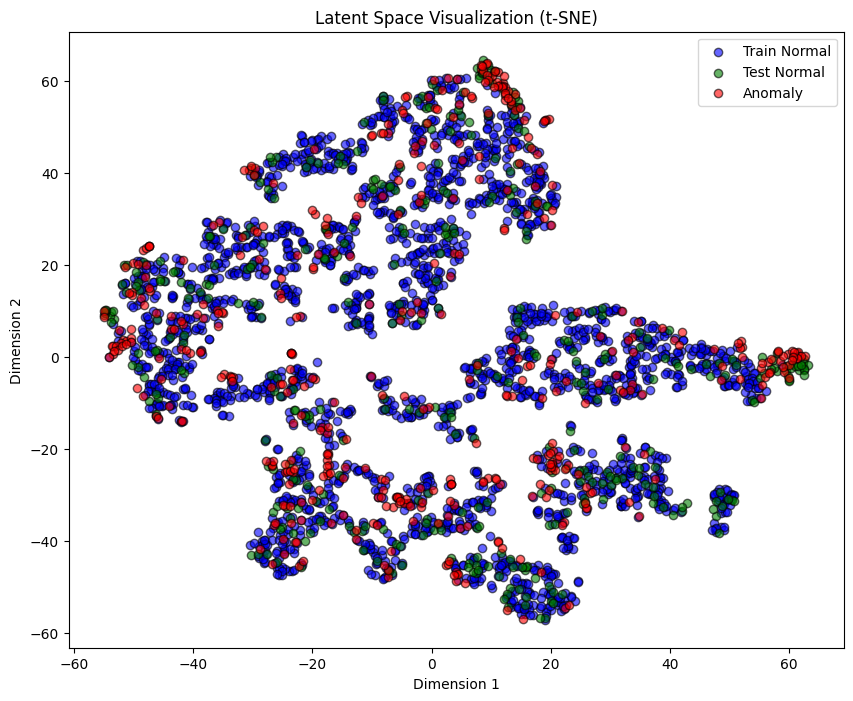

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine all latent vectors and create labels
latent_data = torch.cat([train_latent, test_normal_latent, anomaly_latent]).numpy()
labels = (
    [0] * len(train_latent) +  # 0: Train Normal
    [1] * len(test_normal_latent) +  # 1: Test Normal
    [2] * len(anomaly_latent)  # 2: Anomaly
)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_data)

# Visualize
plt.figure(figsize=(10, 8))
for label, color, name in zip([0, 1, 2], ['blue', 'green', 'red'], ['Train Normal', 'Test Normal', 'Anomaly']):
    plt.scatter(latent_2d[np.array(labels) == label, 0],
                latent_2d[np.array(labels) == label, 1],
                label=name, alpha=0.6, edgecolors='k', color=color)
plt.legend()
plt.title('Latent Space Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()




# Understanding MFCC (Mel-Frequency Cepstral Coefficients)

## What are MFCC?

MFCC (Mel-Frequency Cepstral Coefficients) are a numerical representation commonly used to analyze and classify audio signals, especially in voice and music processing. They are fundamental in many audio processing applications, such as speech recognition, pattern recognition, and anomaly detection in acoustic signals.

### Key Concepts

1. **Mel-Frequency**:
   - The **Mel scale** is a perceptual frequency scale based on how humans hear sounds.
   - Higher frequencies are perceived with less resolution compared to lower frequencies. MFCC capture this non-linearity.

2. **Cepstral Coefficients**:
   - A **cepstrum** is the result of a mathematical transformation applied to an audio signal's frequency spectrum.
   - MFCC represent relevant spectral characteristics of the signal while discarding irrelevant details, such as amplitude variations.

---

## How are MFCC Calculated?

The MFCC calculation involves several transformations of the audio signal:

1. **Fourier Transform (FFT)**:
   - Converts the audio signal from the time domain to the frequency domain.
   - Produces the **frequency spectrum**.

2. **Mel Filter Bank Application**:
   - Passes the frequency spectrum through a set of **Mel-scaled filters** that simulate human perception.
   - Emphasizes low frequencies more than high frequencies.

3. **Logarithm**:
   - Compresses the filter bank output into a log-energy representation.

4. **Discrete Cosine Transform (DCT)**:
   - Reduces the dimensionality of the resulting vector while retaining the most significant coefficients.
   - Produces a set of coefficients (usually 13-20) that encapsulate the key features of the audio.

---

## Why Use MFCC?

1. **Dimensionality Reduction**:
   - Compresses high-dimensional raw audio signals into a compact set of features.

2. **Robustness**:
   - MFCC are relatively robust to noise and signal variations.

3. **Human Perception**:
   - Mimics how humans perceive sound, focusing on perceptually relevant features.

4. **Versatility**:
   - Widely used in fields such as speech recognition, music analysis, environmental sound classification, and anomaly detection.

---

## Applications of MFCC

1. **Speech Recognition**:
   - Used to distinguish between phonemes and words in speech.

2. **Anomaly Detection**:
   - Identifies deviations in normal sound patterns, such as machinery anomalies.

3. **Sound Classification**:
   - Classifies environmental sounds, music genres, or machine-generated audio.

---

## Visualizing MFCC

To better understand MFCC, you can visualize them as a "map" of coefficients over time:

```python
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file
file_path = "example.wav"
signal, sr = librosa.load(file_path, sr=22050)

# Compute MFCC
mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=13)

# Visualize MFCC
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()
```

---

## Summary

MFCC are a powerful feature representation that capture the essential spectral characteristics of audio signals. By compressing the relevant information into a small set of coefficients, they enable efficient and accurate analysis of audio in numerous applications, ranging from speech recognition to anomaly detection.



```
# Questo è formattato come codice
```



